### Environment Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time
import random
import torch.utils.data as data
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import cv2
import sys, os

batch_size = 64
num_classes = 3
learning_rate = 0.001
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device= torch.device("cpu")

root_dir = os.getcwd() + '/data_processing'
image_dir = root_dir + '/all_images/'
train_dir = root_dir + '/train_set_with_label'
test_dir = root_dir + '/test_set_with_label'
val_dir = root_dir + '/val_set_with_label'

In [3]:
len(os.listdir(image_dir))

9029

In [4]:
for file in os.listdir(image_dir):
    assert file.endswith(".jpg")

### Dataloader

In [5]:
class FaceSet(data.Dataset):
    def __init__(self,folder,transform):
        self.transform=transform
        imgs=[os.path.join(folder,f) for f in os.listdir(folder)]
        self.imgs = imgs
        
    def __getitem__(self,index):
        imgpath=self.imgs[index]
        im=Image.open(imgpath)
        if im.mode == "RGBA":
            r, g, b, a=im.split ()
            im=Image.merge ("RGB", (r, g, b))
        elif im.mode!="RGB":
            im=im.convert ("RGB")
        im=self.transform(im)
        symbol = imgpath.split('/')[-1].split('.')[0].split('_')[-1]
        if symbol == "0":
            label = 0
        elif symbol == "1":
            label = 1
        else:
            label = 2
        return (0.2990 * im[0] + 0.5870 * im[1] + 0.1140 * im[2]).unsqueeze(0),label
    
    def __len__(self):
        return len(self.imgs)

In [17]:
class FaceSet(data.Dataset):
    def __init__(self,folder,transform):
        self.transform=transform
        imgs=[os.path.join(folder,f) for f in os.listdir(folder)]
        self.imgs = imgs
        
    def __getitem__(self,index):
        imgpath=self.imgs[index]
        im=Image.open(imgpath)
        if im.mode == "RGBA":
            r, g, b, a=im.split ()
            im=Image.merge ("RGB", (r, g, b))
        elif im.mode!="RGB":
            im=im.convert ("RGB")
        im=self.transform(im)
        symbol = imgpath.split('/')[-1].split('.')[0].split('_')[-1]
        if symbol == "0":
            label = 0
        elif symbol == "1":
            label = 1
        else:
            label = 2
        return (0.2990 * im[0] + 0.5870 * im[1] + 0.1140 * im[2]).unsqueeze(0),label
        
    def __len__(self):
        return len(self.imgs)

In [18]:
transform_train=transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
transform_test=transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

for fn in os.listdir(image_dir):
    im=Image.open(image_dir + fn)
    print(transform_train(im).size())
    break

torch.Size([3, 28, 28])


In [19]:
# define dataset
trainset=FaceSet(train_dir,transform=transform_train)
valset=FaceSet(val_dir,transform=transform_test)
testset=FaceSet(test_dir,transform=transform_test)

### Model Architecture

![title](report_images/MLP_architecture.png)

In [24]:
class mlp(nn.Module):
    def __init__(self, input_size, output_size):
        super(mlp , self).__init__()
        self.layer1 = nn.Linear(input_size, 128 , bias=False)
        #self.layer2 = nn.Linear(256, 128, bias=False)
        self.layer3 = nn.Linear(128, 32, bias=False)
        self.layer4 = nn.Linear(32, output_size, bias=False)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = F.relu(self.layer1(x))
        # x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        y = F.relu(self.layer4(x))
        return y

In [25]:
bs = batch_size
train_loader=torch.utils.data.DataLoader(trainset,batch_size=bs,shuffle=True,num_workers=0)
val_loader=torch.utils.data.DataLoader(valset,batch_size=bs,shuffle=False,num_workers=0)
test_loader=torch.utils.data.DataLoader(testset,batch_size=bs,shuffle=False,num_workers=0)

### Train and Evaluation

In [30]:
model = mlp(28 * 28, 3)
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(train_loader)

In [31]:
total_step = len(train_loader)

epoch_num = range(num_epochs)
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for epoch in range(num_epochs):
    
    ### Train
    correct = 0
    total = 0
    running_loss = 0.0
    model.train()
    for i, (images, labels) in enumerate(train_loader): 
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_acc = correct / total
    train_loss = running_loss / (i+1)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
        
    print ('Train Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
    .format(epoch+1, num_epochs, i+1, total_step, train_loss, train_acc))
    
    ### Evaluation
    correct = 0
    total = 0
    running_loss = 0.0
    model.eval()
    for i, (images, labels) in enumerate(val_loader):  
        images = images.to(device)
        labels = labels.to(device)
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
    val_acc = correct / total
    val_loss = running_loss / (i+1)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
        
    print ('Val Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
    .format(epoch+1, num_epochs, i+1, total_step, val_loss, val_acc))

Train Epoch [1/10], Step [113/113], Loss: 0.8740, Accuracy: 0.6034
Val Epoch [1/10], Step [15/113], Loss: 0.7560, Accuracy: 0.6435
Train Epoch [2/10], Step [113/113], Loss: 0.7297, Accuracy: 0.6707
Val Epoch [2/10], Step [15/113], Loss: 0.7001, Accuracy: 0.6848
Train Epoch [3/10], Step [113/113], Loss: 0.6552, Accuracy: 0.7086
Val Epoch [3/10], Step [15/113], Loss: 0.6322, Accuracy: 0.7217
Train Epoch [4/10], Step [113/113], Loss: 0.5688, Accuracy: 0.7663
Val Epoch [4/10], Step [15/113], Loss: 0.6316, Accuracy: 0.7130
Train Epoch [5/10], Step [113/113], Loss: 0.5169, Accuracy: 0.7918
Val Epoch [5/10], Step [15/113], Loss: 0.5858, Accuracy: 0.7522
Train Epoch [6/10], Step [113/113], Loss: 0.4593, Accuracy: 0.8190
Val Epoch [6/10], Step [15/113], Loss: 0.5494, Accuracy: 0.7772
Train Epoch [7/10], Step [113/113], Loss: 0.4046, Accuracy: 0.8462
Val Epoch [7/10], Step [15/113], Loss: 0.5397, Accuracy: 0.7739
Train Epoch [8/10], Step [113/113], Loss: 0.3617, Accuracy: 0.8622
Val Epoch [8/10]

### Test

In [32]:
### Test
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test set: {} %'.format(100 * correct / total))

Accuracy of the network on the test set: 78.91304347826087 %


### visualization

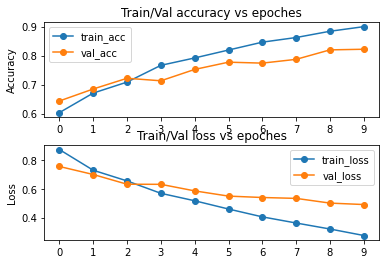

In [33]:
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.plot(epoch_num, train_acc_list, 'o-', label='train_acc')
plt.plot(epoch_num, val_acc_list, 'o-', label='val_acc')
plt.legend()
plt.title('Train/Val accuracy vs epoches')
x = MultipleLocator(1)
ax = plt.gca()
ax.xaxis.set_major_locator(x)
plt.ylabel('Accuracy')
plt.subplots_adjust(wspace=0, hspace=0.3)
plt.subplot(2, 1, 2)
plt.plot(epoch_num, train_loss_list, 'o-', label='train_loss')
plt.plot(epoch_num, val_loss_list, 'o-', label='val_loss')
plt.legend()
plt.title('Train/Val loss vs epoches')
x = MultipleLocator(1)
ax = plt.gca()
ax.xaxis.set_major_locator(x)
plt.ylabel('Loss')
plt.show()

### Reference

Coskun, N., & Yildirim, T. (2003, July). The effects of training algorithms in MLP network on image classification. In Proceedings of the International Joint Conference on Neural Networks, 2003. (Vol. 2, pp. 1223-1226). IEEE.

Ladić, Tin, and Ante Mandekić. "Face mask classification using MLP Classifier." Ri-STEM-2021 10.68 (2021): 77.